In [170]:
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("./data/preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("./data/preprocessed_pes_with_energy.parquet")

In [171]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)



feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit', "outage"])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

### __Wind Energy Forecast__

__baseline__

In [184]:
import model_utils
import numpy as np
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_wind\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_wind\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.30000000000000004 from qr_model_wind\qr_model_quantile_0.30000000000000004.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_wind\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_wind\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_wind\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7000000000000001 from qr_model_wind\qr_model_quantile_0.7000000000000001.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_wind\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_wind\qr_model_quantile_0

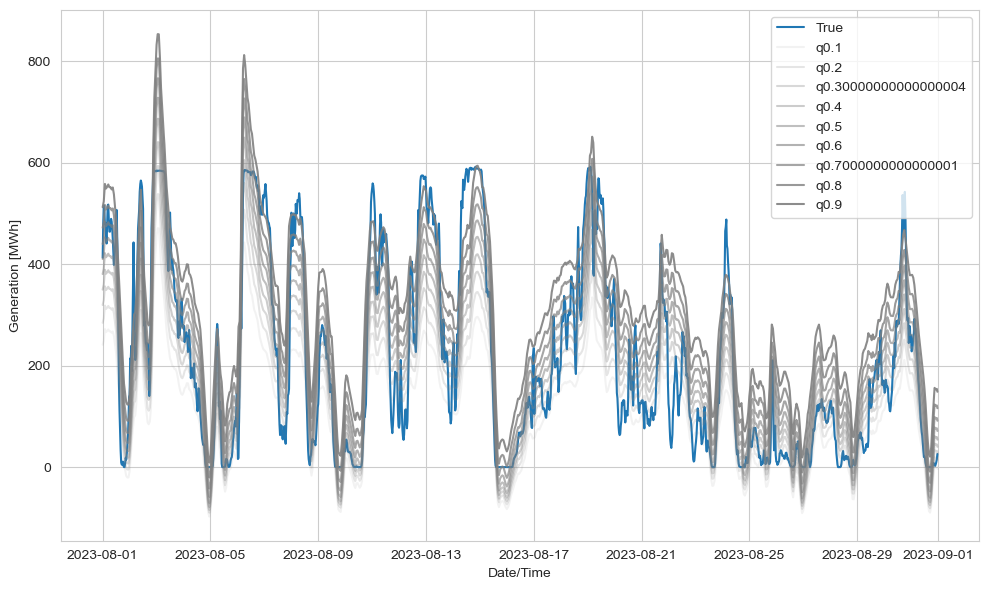

In [185]:
qr_model_wind.plot_quantils(feature_engineerer_wind_baseline.y_test.index, qr_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023, month=8)

__xgboost__

In [186]:
importlib.reload(model_utils)
import numpy as np

quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_wind"
hyperparams = {
            # Use the quantile objective function.
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": quantiles,
            "learning_rate": 0.01,
            "max_depth": 8
        }




xgboost_model_wind = model_utils.XGBoostModel(feature_engineerer_wind, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False, hyperparams=hyperparams, num_boost_round=45, early_stopping_rounds=10)
xgboost_model_wind.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_wind.pinball_score()}")

[0]	Train-quantile:97.94281	Val-quantile:88.92861
[1]	Train-quantile:96.90376	Val-quantile:88.00129
[2]	Train-quantile:95.87648	Val-quantile:87.07804
[3]	Train-quantile:94.86318	Val-quantile:86.16643
[4]	Train-quantile:93.85950	Val-quantile:85.26481
[5]	Train-quantile:92.87140	Val-quantile:84.37620
[6]	Train-quantile:91.89501	Val-quantile:83.49854
[7]	Train-quantile:90.92979	Val-quantile:82.62873
[8]	Train-quantile:89.97722	Val-quantile:81.76998
[9]	Train-quantile:89.03306	Val-quantile:80.92201
[10]	Train-quantile:88.10202	Val-quantile:80.08375
[11]	Train-quantile:87.18031	Val-quantile:79.24969
[12]	Train-quantile:86.26714	Val-quantile:78.42198
[13]	Train-quantile:85.36730	Val-quantile:77.60982
[14]	Train-quantile:84.47712	Val-quantile:76.80801
[15]	Train-quantile:83.59958	Val-quantile:76.01950
[16]	Train-quantile:82.73463	Val-quantile:75.23744
[17]	Train-quantile:81.87429	Val-quantile:74.46506
[18]	Train-quantile:81.02575	Val-quantile:73.69916
[19]	Train-quantile:80.18591	Val-quantile

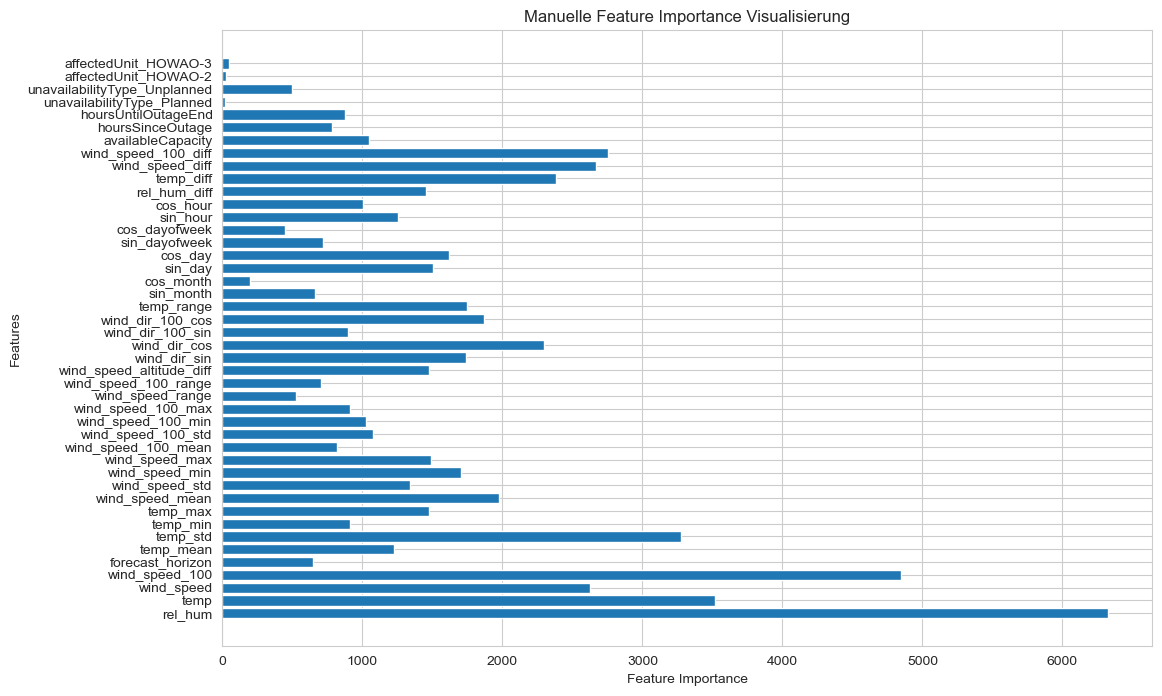

In [187]:
xgboost_model_wind.plot_feature_importance()

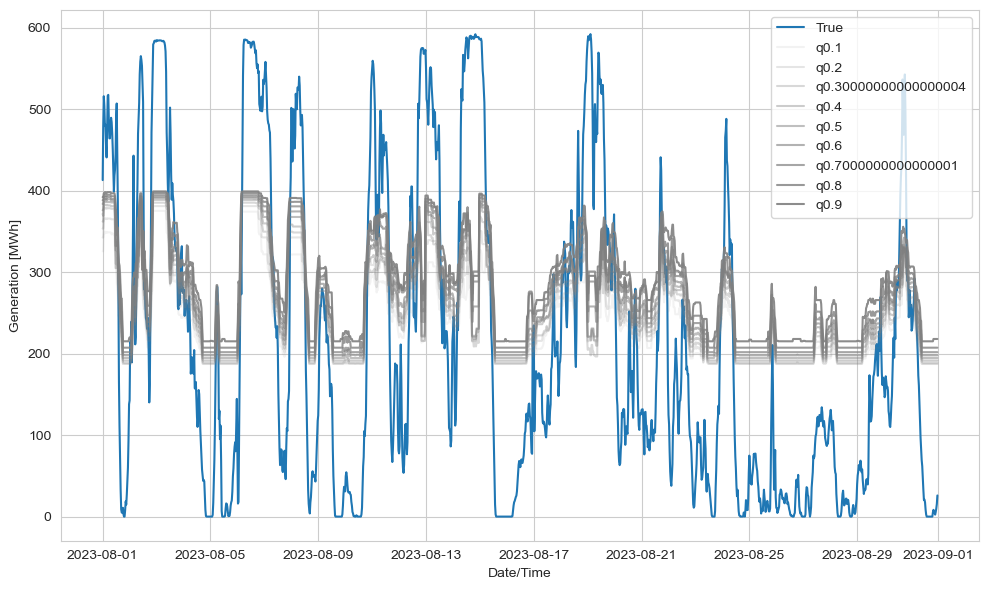

In [188]:
xgboost_model_wind.plot_quantils(daterange=feature_engineerer_wind.y_test.index, y=xgboost_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023, month=8)

### __Solar Energy Forecast__

__baseline modell__

In [189]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_solar\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_solar\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.30000000000000004 from qr_model_solar\qr_model_quantile_0.30000000000000004.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_solar\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_solar\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_solar\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7000000000000001 from qr_model_solar\qr_model_quantile_0.7000000000000001.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_solar\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_solar\qr_model_q

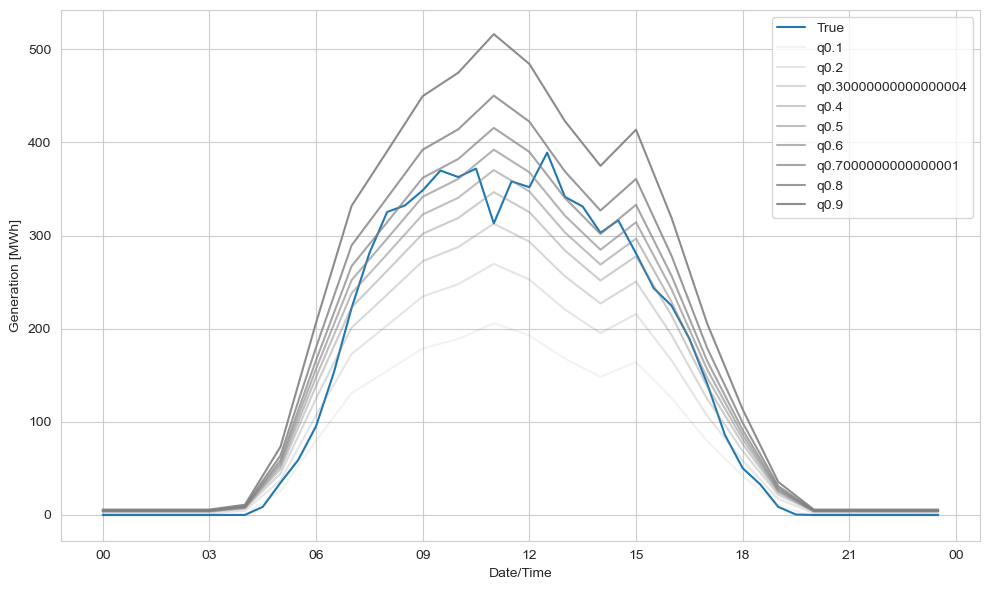

In [190]:
qr_model_solar.plot_quantils(daterange=feature_engineerer_solar_baseline.y_test.index, y=qr_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1),period="day", year=2023, month=8, day=1)

__xgboost__

In [191]:
quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_solar"

xgboost_model_solar = model_utils.XGBoostModel(feature_engineerer_solar, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False)
xgboost_model_solar.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_solar.pinball_score()}")

[0]	Train-quantile:44.04568	Val-quantile:89.97644
[1]	Train-quantile:42.04382	Val-quantile:86.15632
[2]	Train-quantile:40.14450	Val-quantile:82.40944
[3]	Train-quantile:38.36707	Val-quantile:78.89517
[4]	Train-quantile:36.65874	Val-quantile:75.50360
[5]	Train-quantile:35.09182	Val-quantile:72.22041
[6]	Train-quantile:33.61899	Val-quantile:68.98687
[7]	Train-quantile:32.21615	Val-quantile:65.95456
[8]	Train-quantile:30.87827	Val-quantile:63.05880
[9]	Train-quantile:29.60965	Val-quantile:60.33811
[10]	Train-quantile:28.40209	Val-quantile:57.75915
[11]	Train-quantile:27.25022	Val-quantile:55.29151
[12]	Train-quantile:26.15598	Val-quantile:52.89711
[13]	Train-quantile:25.12634	Val-quantile:50.64342
[14]	Train-quantile:24.13578	Val-quantile:48.51355
[15]	Train-quantile:23.20739	Val-quantile:46.47714
[16]	Train-quantile:22.31912	Val-quantile:44.55036
[17]	Train-quantile:21.48935	Val-quantile:42.72812
[18]	Train-quantile:20.68899	Val-quantile:40.96316
[19]	Train-quantile:19.92640	Val-quantile

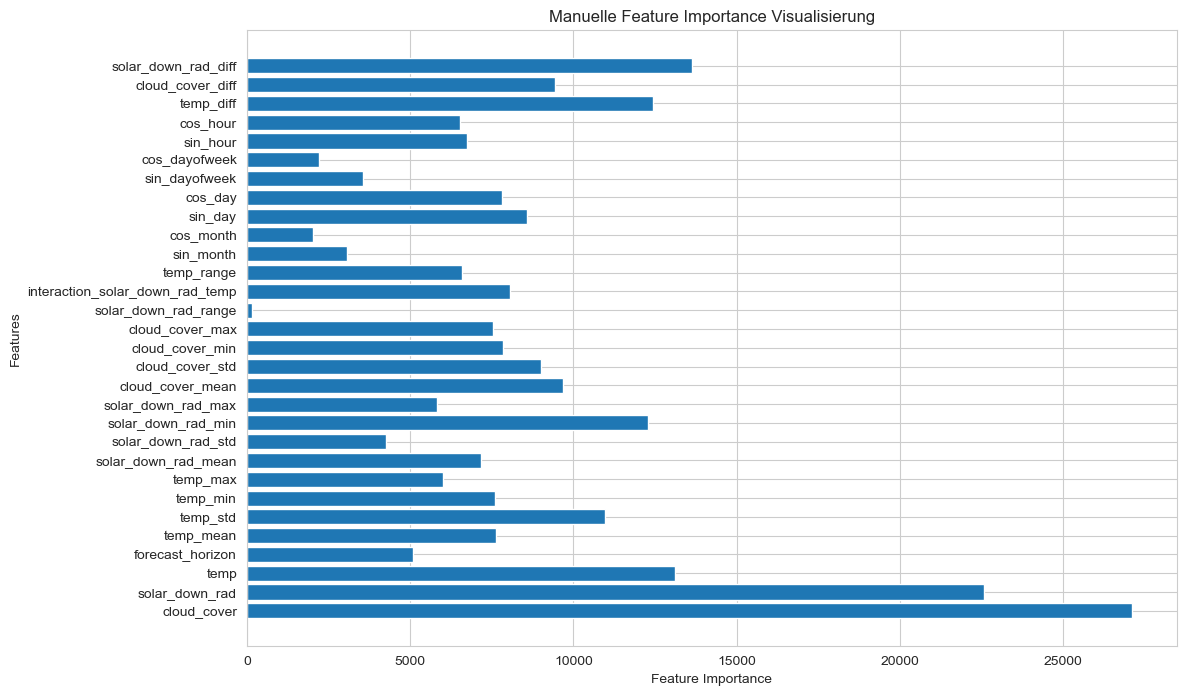

In [192]:
xgboost_model_solar.plot_feature_importance()

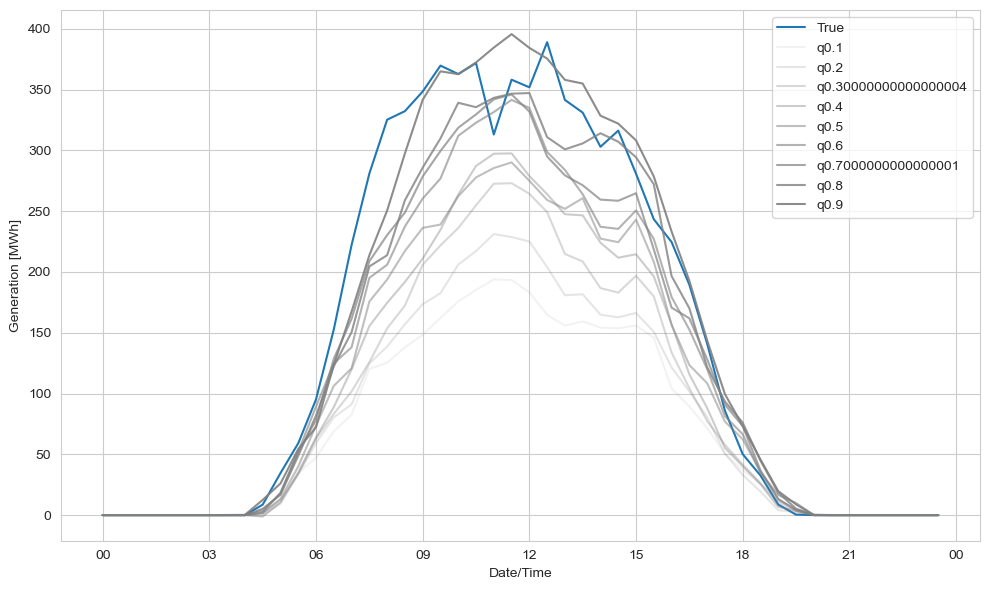

In [193]:
xgboost_model_solar.plot_quantils(daterange=feature_engineerer_solar.y_test.index, y=xgboost_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), period="day", year=2023, month=8, day=1)

### __Lightgbm implementation__

In [194]:
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind"

lgbm_model_wind = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind.pinball_score()}")

[LightGBM] [Info] Total Bins 8137
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 50
[LightGBM] [Info] Start training from score 9.924001
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 9.64158	valid's quantile: 11.4061
[100]	train's quantile: 8.37053	valid's quantile: 11.3581
Early stopping, best iteration is:
[86]	train's quantile: 8.60428	valid's quantile: 11.3447
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_wind\qr_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 8137
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 50
[LightGBM] [Info] Start training from score 46.169998
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 13.6723	valid's quantile: 17.3394
[100]	train's quantile: 12.2827	valid's quantile: 17.2185
Early stopping, best iteration is:
[80]	train's quantile: 12.7181	valid's quantile: 17.1572
Saved Quan

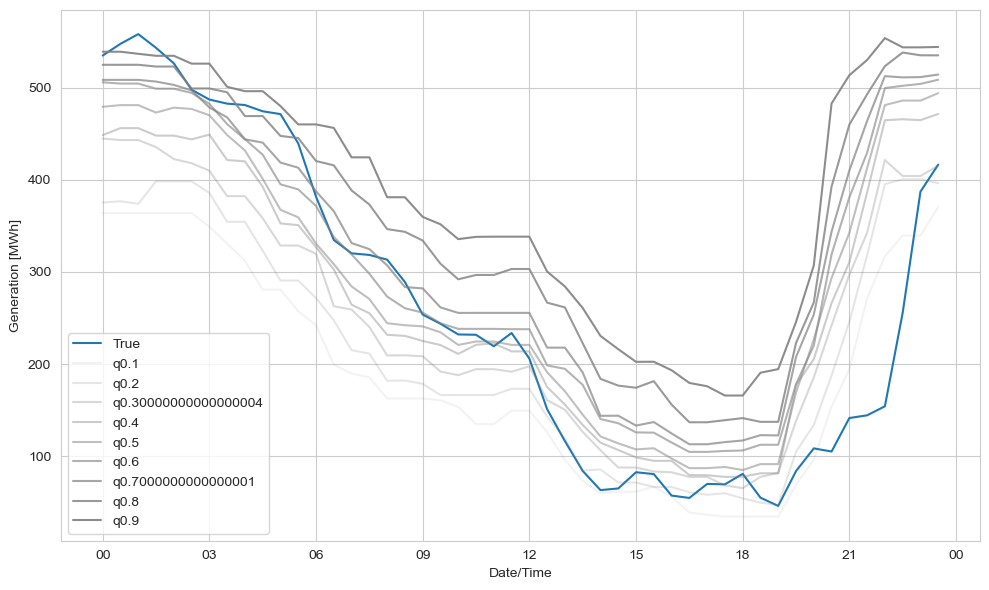

In [197]:
lgbm_model_wind.plot_quantils(feature_engineerer_wind.y_test.index, lgbm_model_wind.q_predictions, quantiles, period="day", year=2023, month=8 , day=7)

In [198]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar"

lgbm_model_solar = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_solar.pinball_score()}")

[LightGBM] [Info] Total Bins 5789
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 30
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 4.74848	valid's quantile: 6.34295
[100]	train's quantile: 3.8096	valid's quantile: 5.73706
[150]	train's quantile: 3.6255	valid's quantile: 5.7163
[200]	train's quantile: 3.49789	valid's quantile: 5.6917
Early stopping, best iteration is:
[197]	train's quantile: 3.49848	valid's quantile: 5.69024
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_solar\qr_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 5789
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 30
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 6.68977	valid's quantile: 9.05413
[100]	train's quantile: 5.64683	valid's quantile: 8.74994
[150]	train's quantile: 5.36007	valid's quantile: 8.76201
Early stopping, best iteration is:
[1

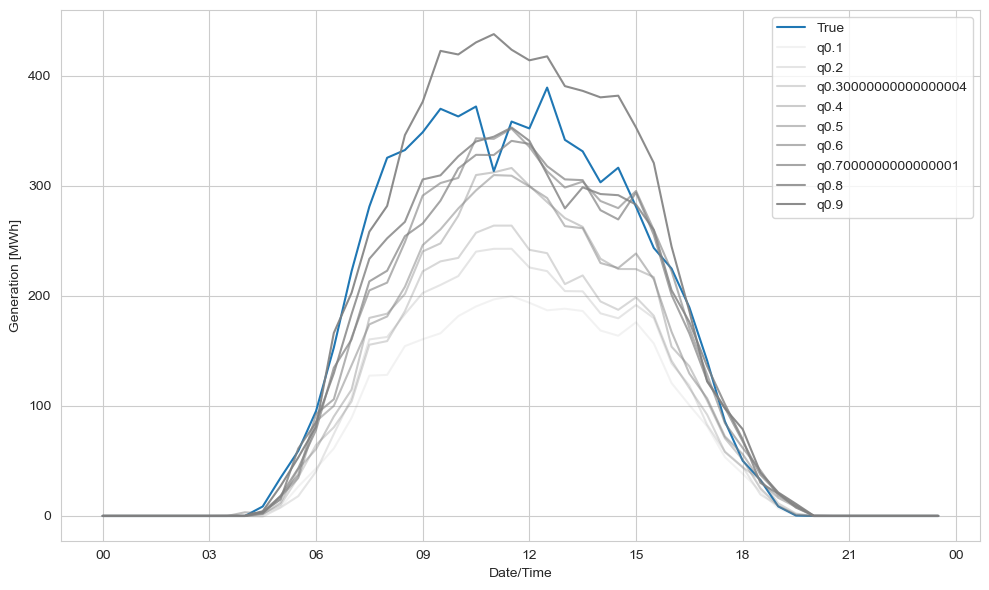

In [201]:
lgbm_model_solar.plot_quantils(feature_engineerer_solar.y_test.index, lgbm_model_solar.q_predictions, quantiles, period="day", year=2023, month=8, day=1)

In [202]:
import neural_networks
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn
quantiles = np.arange(0.1, 1.0, 0.1)

nn_wind = neural_networks.Trainer(feature_engineerer_wind, neural_networks.q_model,quantiles)
nn_wind.train_and_test()

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 287.27392578125
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 237.36868286132812
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 212.79010009765625
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 206.12657165527344
40. epoche startet: 
41. epoche startet: 
42. epoche star

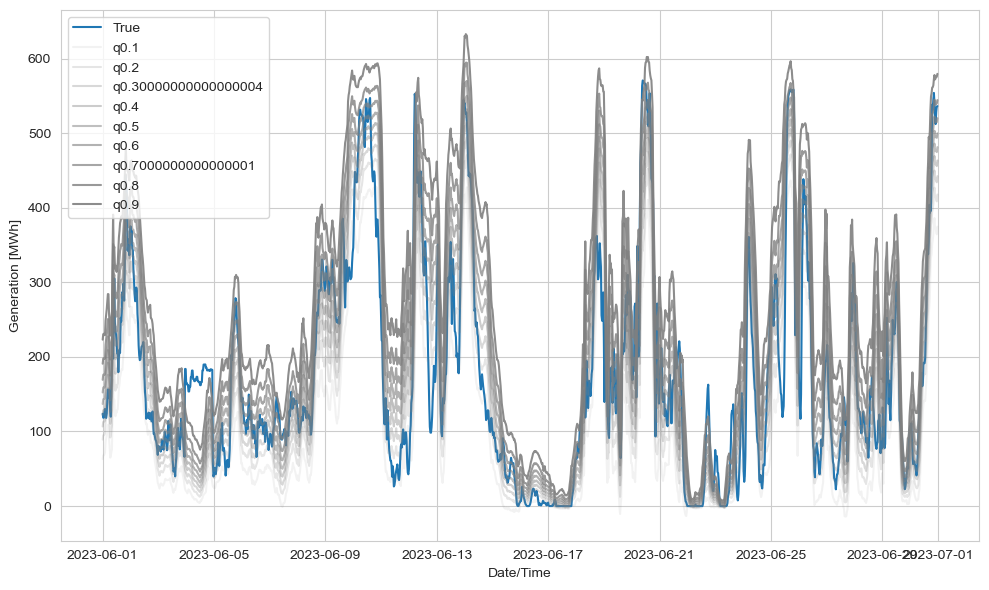

In [205]:
nn_wind.plot_quantils(feature_engineerer_wind.y_test.index, nn_wind.q_prediction_nn, quantiles, year=2023, month=6)

In [ ]:
import neural_networks
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn
quantiles = np.arange(0.1, 1.0, 0.1)

nn_solar = neural_networks.Trainer(feature_engineerer_solar, neural_networks.q_model, quantiles, in_shape=30)
nn_solar.train_and_test()

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 91.86357879638672
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 85.7209243774414
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 82.63983917236328
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 81.15238189697266
40. epoche startet: 
41. epoche startet: 
42. epoche starte

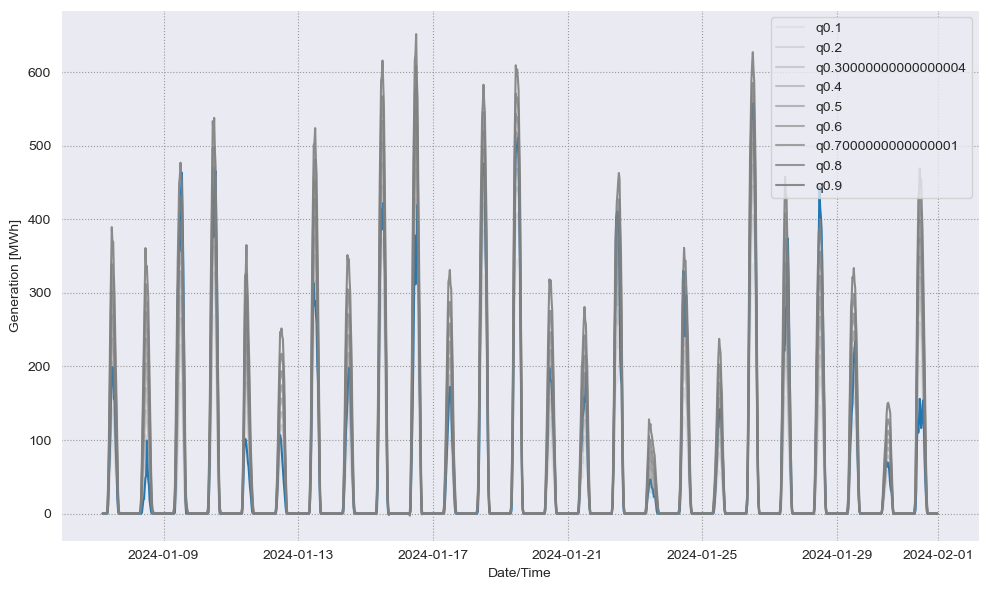

In [23]:
nn_solar.plot_quantils(feature_engineerer_solar.y_test, nn_solar.q_prediction_nn, quantiles)